In [1]:
import stanza
import pandas as pd

In [2]:
stanza.download('de', processors='tokenize,sentiment')


nlp = stanza.Pipeline(lang='de', processors='tokenize,sentiment')

2024-05-06 09:30:26 INFO: Downloaded file to /Users/ullasattler/stanza_resources/resources.json
2024-05-06 09:30:26 WARNING: Language de package default expects mwt, which has been added
2024-05-06 09:30:26 INFO: Downloading these customized packages for language: de (German)...
| Processor       | Package      |
----------------------------------
| tokenize        | gsd          |
| mwt             | gsd          |
| sentiment       | sb10k_charlm |
| pretrain        | conll17      |
| forward_charlm  | newswiki     |
| backward_charlm | newswiki     |

2024-05-06 09:30:26 INFO: File exists: /Users/ullasattler/stanza_resources/de/tokenize/gsd.pt
2024-05-06 09:30:26 INFO: File exists: /Users/ullasattler/stanza_resources/de/mwt/gsd.pt
2024-05-06 09:30:26 INFO: File exists: /Users/ullasattler/stanza_resources/de/sentiment/sb10k_charlm.pt
2024-05-06 09:30:27 INFO: File exists: /Users/ullasattler/stanza_resources/de/pretrain/conll17.pt
2024-05-06 09:30:27 INFO: File exists: /Users/ullasatt

2024-05-06 09:30:27 INFO: Downloaded file to /Users/ullasattler/stanza_resources/resources.json
2024-05-06 09:30:27 WARNING: Language de package default expects mwt, which has been added
2024-05-06 09:30:27 INFO: Loading these models for language: de (German):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| sentiment | sb10k_charlm |

2024-05-06 09:30:27 INFO: Using device: cpu
2024-05-06 09:30:27 INFO: Loading: tokenize
2024-05-06 09:30:28 INFO: Loading: mwt
2024-05-06 09:30:28 INFO: Loading: sentiment
2024-05-06 09:30:28 INFO: Done loading processors!


In [106]:
df2 = pd.read_csv('subset_studium.csv', sep=';', nrows=700)
df4= df2
df5= df2

In [65]:
column = df2["Studium"]
texts2 = column.tolist()

In [66]:
nlp = stanza.Pipeline(lang='de', processors='tokenize,sentiment')

2024-05-06 13:39:54 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-06 13:39:54 INFO: Downloaded file to /Users/ullasattler/stanza_resources/resources.json
2024-05-06 13:39:54 WARNING: Language de package default expects mwt, which has been added
2024-05-06 13:39:54 INFO: Loading these models for language: de (German):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| sentiment | sb10k_charlm |

2024-05-06 13:39:54 INFO: Using device: cpu
2024-05-06 13:39:54 INFO: Loading: tokenize
2024-05-06 13:39:54 INFO: Loading: mwt
2024-05-06 13:39:54 INFO: Loading: sentiment
2024-05-06 13:39:54 INFO: Done loading processors!


In [ ]:
#negative, neutral, and positive, represented by 0, 1, 2 

In [77]:
total_sentiment = 0
neg = 0
pos = 0
neutr = 0

for i, text in enumerate(texts2):
    doc = nlp(text)
    text_sentiment = 0
    word_count_all = 0
   # counter = 1
    b
    for sentence in doc.sentences:
        word_count = len(sentence.words)
        word_count_all += word_count
        text_sentiment += (sentence.sentiment * word_count)

    

        #print(f"Wörter: {word_count}")
       
        #print(f"Senti: {sentence.sentiment}")
        
        #print(f"wordcount_all: {word_count_all}")
    
    total_sentiment = text_sentiment / word_count_all
    
    if total_sentiment <= 2.0 and total_sentiment >= 1.4:
        pos += 1
        sentiment= "positive"
    elif total_sentiment <= 1.3 and total_sentiment >= 0.8:
        neutr += 1
        sentiment= "neutral"
    else:
        neg += 1
        sentiment= "negative"
    #print(f"{i + 1} -> Overall Sentiment: {sentiment}")
    df2.loc[i, 'Sentiment'] = sentiment
print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")



Neg: 125 Pos: 278 Neutr: 297


In [78]:
df2.to_csv('subset_studium_with_sentiment.csv', sep=';', index=False)

In [103]:
df3 = pd.read_csv('subset_studium_with_sentiment.csv', sep=';', nrows=700)
df3 = df3[df3['Studium_Label'].notnull()]
df3.head()

,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",negative
1,1,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


In [81]:
def calculateMatch(df):
    match_count = (df['Studium_Label'] == df['Sentiment']).sum()
    return match_count

In [104]:
print(calculateMatch(df3))

240


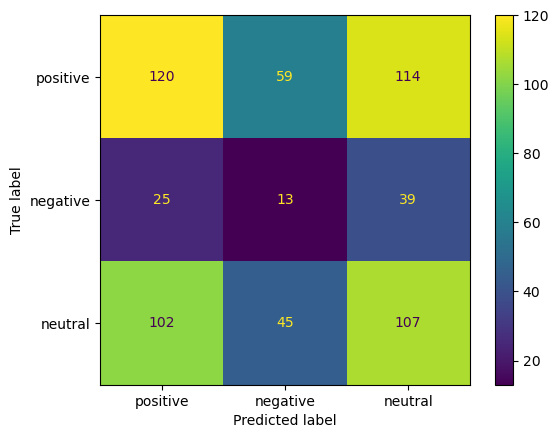

0.38461538461538464
              precision    recall  f1-score   support

    positive       0.11      0.17      0.13        77
    negative       0.41      0.42      0.42       254
     neutral       0.49      0.41      0.44       293

    accuracy                           0.38       624
   macro avg       0.34      0.33      0.33       624
weighted avg       0.41      0.38      0.39       624



In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt
df3['Studium_Label'] = df3['Studium_Label'].astype(str)
df3['Sentiment'] = df3['Sentiment'].astype(str)
confusion_mat = confusion_matrix(df3['Studium_Label'], df3['Sentiment'], labels=['positive', 'negative', 'neutral'])

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()
print(f1_score(df5['Studium_Label'], df3['Sentiment'], labels=['positive', 'negative', 'neutral'], average='micro'))
print(classification_report(
    df3['Studium_Label'],
    df3['Sentiment'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))

In [93]:
total_sentiment = 0
neg = 0
pos = 0
neutr = 0

for i, text in enumerate(texts2):
    doc = nlp(text)
    text_sentiment = 0
    word_count_all = 0
   # counter = 1
    
    for sentence in doc.sentences:
        word_count = len(sentence.words)
        word_count_all += word_count
        text_sentiment += (sentence.sentiment * word_count)

    

        #print(f"Wörter: {word_count}")
       
        #print(f"Senti: {sentence.sentiment}")
        
        #print(f"wordcount_all: {word_count_all}")
    
    total_sentiment = text_sentiment / word_count_all
    
    if total_sentiment <= 2.0 and total_sentiment >= 1.2:
        pos += 1
        sentiment= "positive"
    elif total_sentiment <= 1.3 and total_sentiment >= 0.9:
        neutr += 1
        sentiment= "neutral"
    else:
        neg += 1
        sentiment= "negative"
    #print(f"{i + 1} -> Overall Sentiment: {sentiment}")
    df4.loc[i, 'Sentiment'] = sentiment
print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")



Neg: 44 Pos: 475 Neutr: 181


In [94]:
df4.to_csv('subset_studium_with_sentiment2.csv', sep=';', index=False)

In [96]:
df5 = pd.read_csv('subset_studium_with_sentiment.csv', sep=';', nrows=700)
df5 = df4[df4['Studium_Label'].notnull()]
df5.head()

,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",positive
1,1,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,negative
2,2,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


In [97]:
print(calculateMatch(df5))

281


/var/folders/sh/p04d971d04n_x65451fzf2t00000gn/T/ipykernel_75701/3423251584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Studium_Label'] = df5['Studium_Label'].astype(str)
/var/folders/sh/p04d971d04n_x65451fzf2t00000gn/T/ipykernel_75701/3423251584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Sentiment'] = df5['Sentiment'].astype(str)


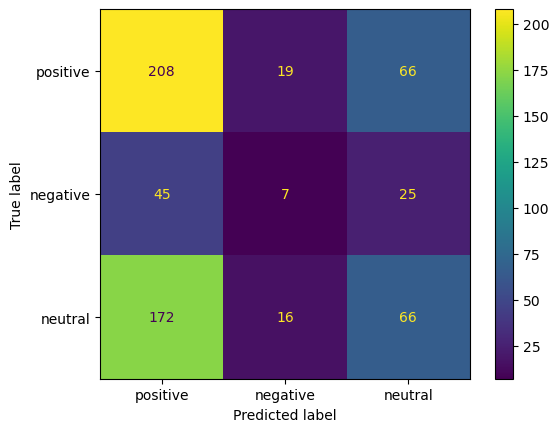

0.45032051282051283
              precision    recall  f1-score   support

    positive       0.17      0.09      0.12        77
    negative       0.42      0.26      0.32       254
     neutral       0.49      0.71      0.58       293

    accuracy                           0.45       624
   macro avg       0.36      0.35      0.34       624
weighted avg       0.42      0.45      0.42       624



In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt
df5['Studium_Label'] = df5['Studium_Label'].astype(str)
df5['Sentiment'] = df5['Sentiment'].astype(str)
confusion_mat = confusion_matrix(df5['Studium_Label'], df5['Sentiment'], labels=['positive', 'negative', 'neutral'])

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()
print(f1_score(df5['Studium_Label'], df5['Sentiment'], labels=['positive', 'negative', 'neutral'], average='micro'))
print(classification_report(
    df5['Studium_Label'],
    df5['Sentiment'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))

In [107]:
total_sentiment = 0
neg = 0
pos = 0
neutr = 0

for i, text in enumerate(texts2):
    doc = nlp(text)
    text_sentiment = 0
    word_count_all = 0
   # counter = 1
    
    for sentence in doc.sentences:
        word_count = len(sentence.words)
        word_count_all += word_count
        text_sentiment += (sentence.sentiment * word_count)

    

        #print(f"Wörter: {word_count}")
       
        #print(f"Senti: {sentence.sentiment}")
        
        #print(f"wordcount_all: {word_count_all}")
    
    total_sentiment = text_sentiment / word_count_all
    
    if total_sentiment <= 2.0 and total_sentiment >= 1.2:
        pos += 1
        sentiment= "positive"
    elif total_sentiment <= 1.3 and total_sentiment >= 0.7:
        neutr += 1
        sentiment= "neutral"
    else:
        neg += 1
        sentiment= "negative"
    #print(f"{i + 1} -> Overall Sentiment: {sentiment}")
    df5.loc[i, 'Sentiment'] = sentiment
print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")

Neg: 12 Pos: 475 Neutr: 213
